In [9]:
import gym
import gym_gridworlds
from stable_baselines3 import PPO

In [8]:
# Define a simple GridWorld environment
class GridWorldEnv(gym.Env):
    def __init__(self):
        super(GridWorldEnv, self).__init__()
        self.observation_space = gym.spaces.Discrete(16)  # 4x4 grid
        self.action_space = gym.spaces.Discrete(4)  # Up, Down, Left, Right
        self.state = 0

    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        if action == 0 and self.state >= 4:  # Up
            self.state -= 4
        elif action == 1 and self.state < 12:  # Down
            self.state += 4
        elif action == 2 and self.state % 4 > 0:  # Left
            self.state -= 1
        elif action == 3 and self.state % 4 < 3:  # Right
            self.state += 1
        reward = 1 if self.state == 15 else 0
        done = self.state == 15
        return self.state, reward, done, {}

    def render(self):
        grid = np.arange(16).reshape((4, 4))
        grid[self.state // 4, self.state % 4] = -1
        print(grid)

In [10]:
# Set up the GridWorld environment
env = GridWorldEnv()

# Train a normal PPO policy
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 61       |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 3983     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 42.9        |
|    ep_rew_mean          | 1           |
| time/                   |             |
|    fps                  | 2632        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015781505 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.712      |
|    learning_rate        | 0.

In [11]:
# Modify hyperparameters to promote overfitting
overfit_model = PPO('MlpPolicy', env, verbose=1, n_steps=128, batch_size=32)
overfit_model.learn(total_timesteps=50000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.3     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 2897     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 41.5         |
|    ep_rew_mean          | 1            |
| time/                   |              |
|    fps                  | 1816         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0004718555 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    en

In [13]:
def membership_inference(env, model, test_states):
    results = []
    for state in test_states:
        env.reset()
        #env.env.s = state  # Set the environment to the test state
        action, _ = model.predict(state)
        next_state, reward, done, _ = env.step(action)
        results.append((state, action, reward, done, next_state))
    return results

# Test with some states
test_states = [env.reset() for _ in range(10)]
inference_results = membership_inference(env, overfit_model, test_states)
print(inference_results)


[(0, array(1), 0, False, 4), (0, array(1), 0, False, 4), (0, array(1), 0, False, 4), (0, array(1), 0, False, 4), (0, array(1), 0, False, 4), (0, array(1), 0, False, 4), (0, array(1), 0, False, 4), (0, array(1), 0, False, 4), (0, array(1), 0, False, 4), (0, array(1), 0, False, 4)]


In [14]:
import torch
from stable_baselines3.common.utils import get_schedule_fn

class GradientBasedAttack:
    def __init__(self, model, env):
        self.model = model
        self.env = env
    
    def extract_gradients(self):
        optimizer = torch.optim.Adam(self.model.policy.parameters(), lr=3e-4)
        for _ in range(10):  # Limited steps for demonstration
            obs = self.env.reset()
            obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action, _ = self.model.predict(obs)
            action = torch.tensor(action, dtype=torch.long).unsqueeze(0)
            log_prob = self.model.policy.evaluate_actions(obs, action)[1]
            loss = -log_prob.mean()
            optimizer.zero_grad()
            loss.backward()
            gradients = [param.grad for param in self.model.policy.parameters()]
            optimizer.step()
            yield gradients

# Perform gradient-based attack
attack = GradientBasedAttack(overfit_model, env)
for grads in attack.extract_gradients():
    print(grads)


[tensor([[ 0.0020,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0021,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0040,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0016,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0010,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0052,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]), tensor([ 0.0020, -0.0021, -0.0040, -0.0036, -0.0032, -0.0028,  0.0023,  0.0024,
        -0.0008,  0.0007, -0.0011, -0.0019,  0.0005, -0.0014, -0.0005,  0.0012,
         0.0031,  0.0010, -0.0003,  0.0029, -0.0007, -0.0022, -0.0030,  0.0027,
         0.0014,  0.0061, -0.0020,  0.0013, -0.0019,  0.0002,  0.0008, -0.0029,
         0.0020, -0.0010,  0.0008, -0.0004, -0.0011, -0.0002, -0.0015, -0.0031,
        -0.0017, -0.0045, -0.0010,  0.0031,  0.0009,  0.0001,  0.0020, -0.0017,
        -0.0013,  0.0006,  0.0019, -0.0003,  0.0054, -0.0033, -0.0003, -0.0003,
    

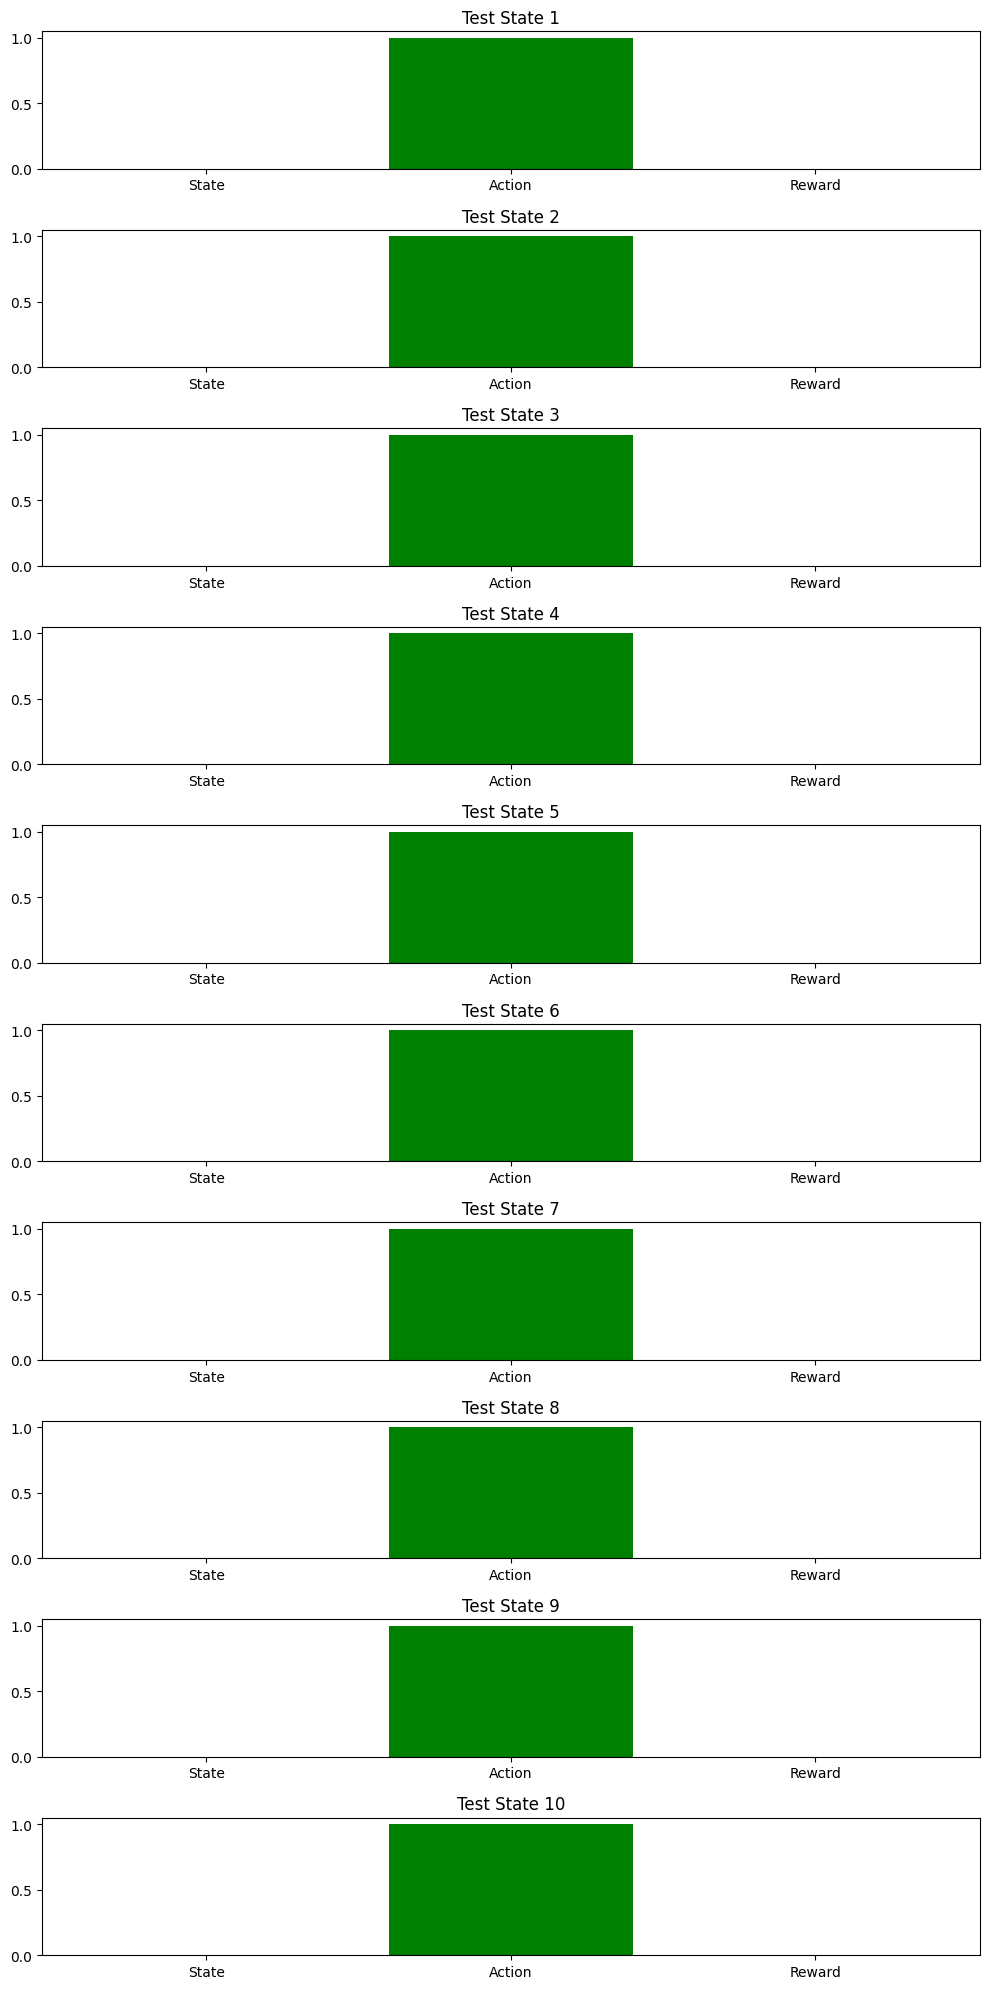

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot membership inference results
def plot_membership_inference(results):
    fig, axs = plt.subplots(len(results), figsize=(10, len(results) * 2))
    for i, (state, action, reward, done, next_state) in enumerate(results):
        axs[i].bar(['State', 'Action', 'Reward'], [np.sum(state), action, reward], color=['blue', 'green', 'red'])
        axs[i].set_title(f'Test State {i+1}')
    plt.tight_layout()
    plt.show()

# Visualize the membership inference results
plot_membership_inference(inference_results)


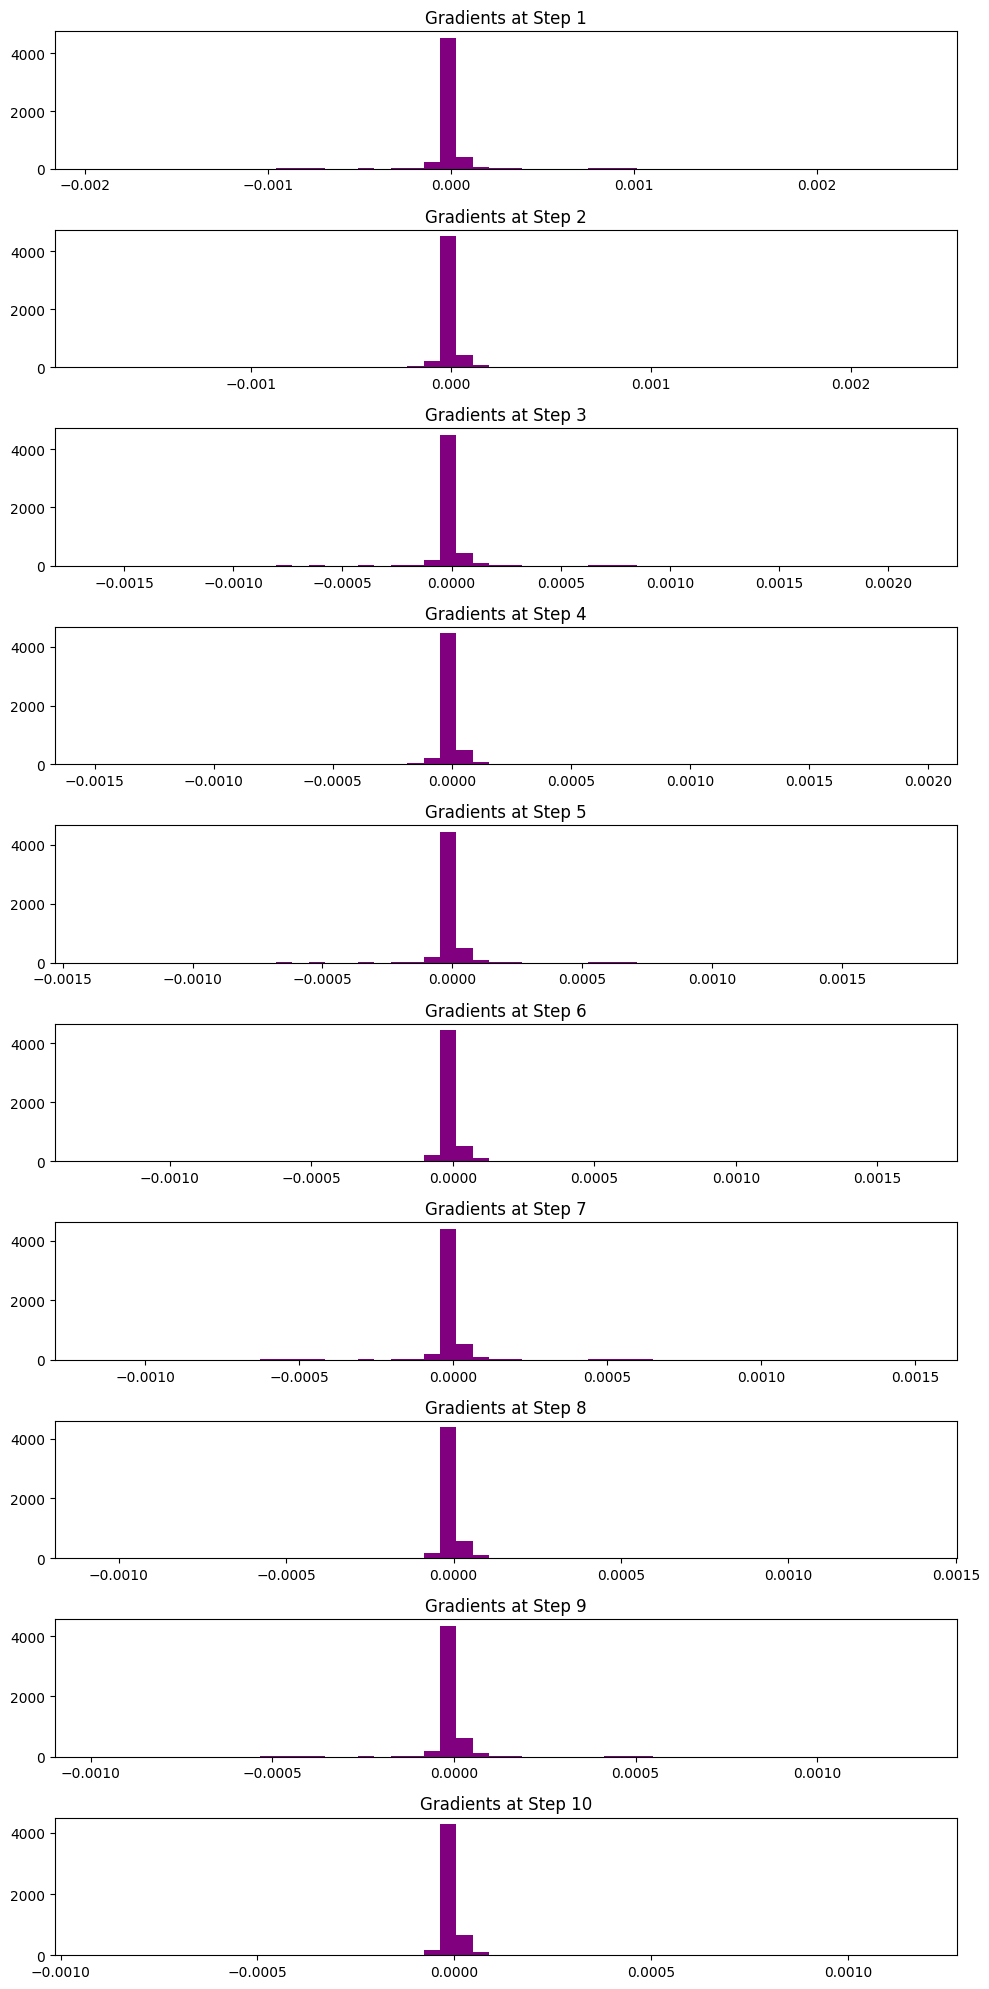

In [16]:
# Function to plot gradient-based attack results
def plot_gradient_based_attack(gradients):
    fig, axs = plt.subplots(len(gradients), figsize=(10, len(gradients) * 2))
    for i, grad in enumerate(gradients):
        grad_values = np.concatenate([g.flatten().detach().numpy() for g in grad if g is not None])
        axs[i].hist(grad_values, bins=50, color='purple')
        axs[i].set_title(f'Gradients at Step {i+1}')
    plt.tight_layout()
    plt.show()

# Visualize the gradient-based attack results
gradients = list(attack.extract_gradients())
plot_gradient_based_attack(gradients)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 53.3     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 4072     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 38.9         |
|    ep_rew_mean          | 1            |
| time/                   |              |
|    fps                  | 2699         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0094884075 |
|    clip_fraction        | 0.0747       |
|    clip_range           | 0.2          |
|    en

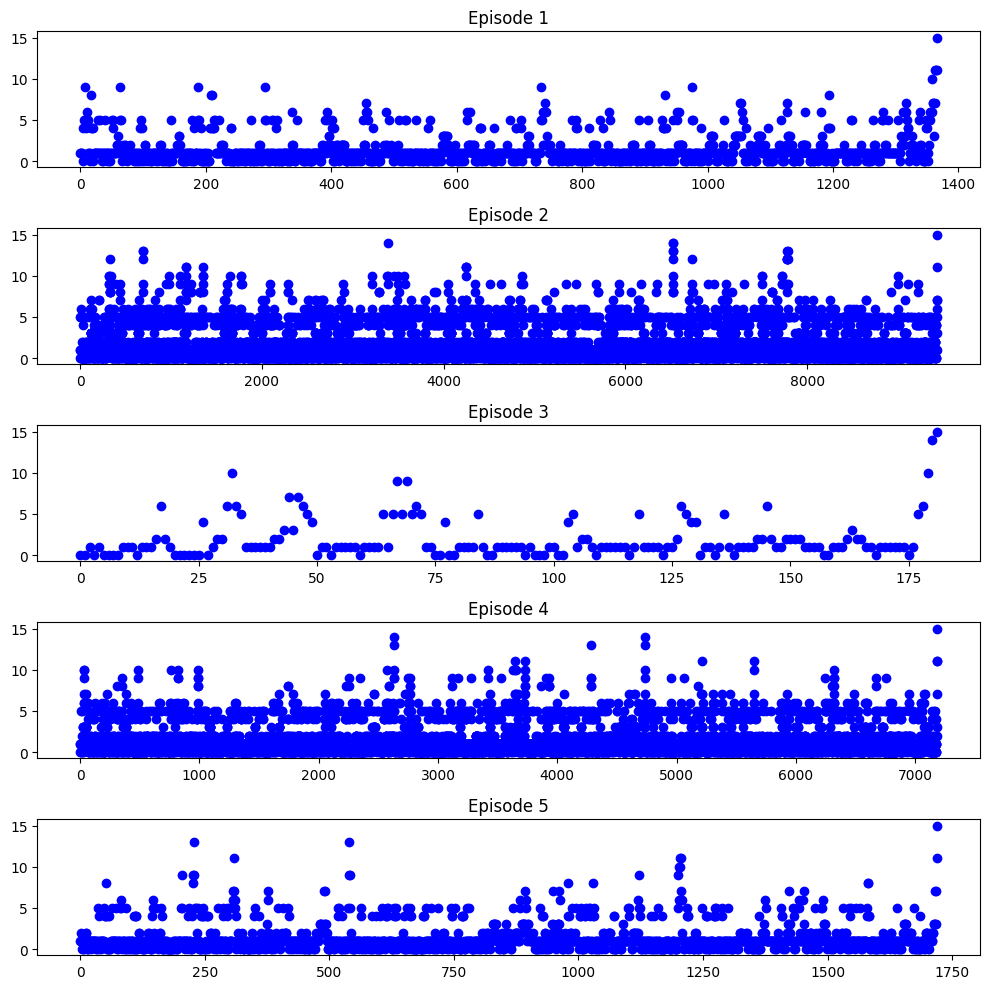

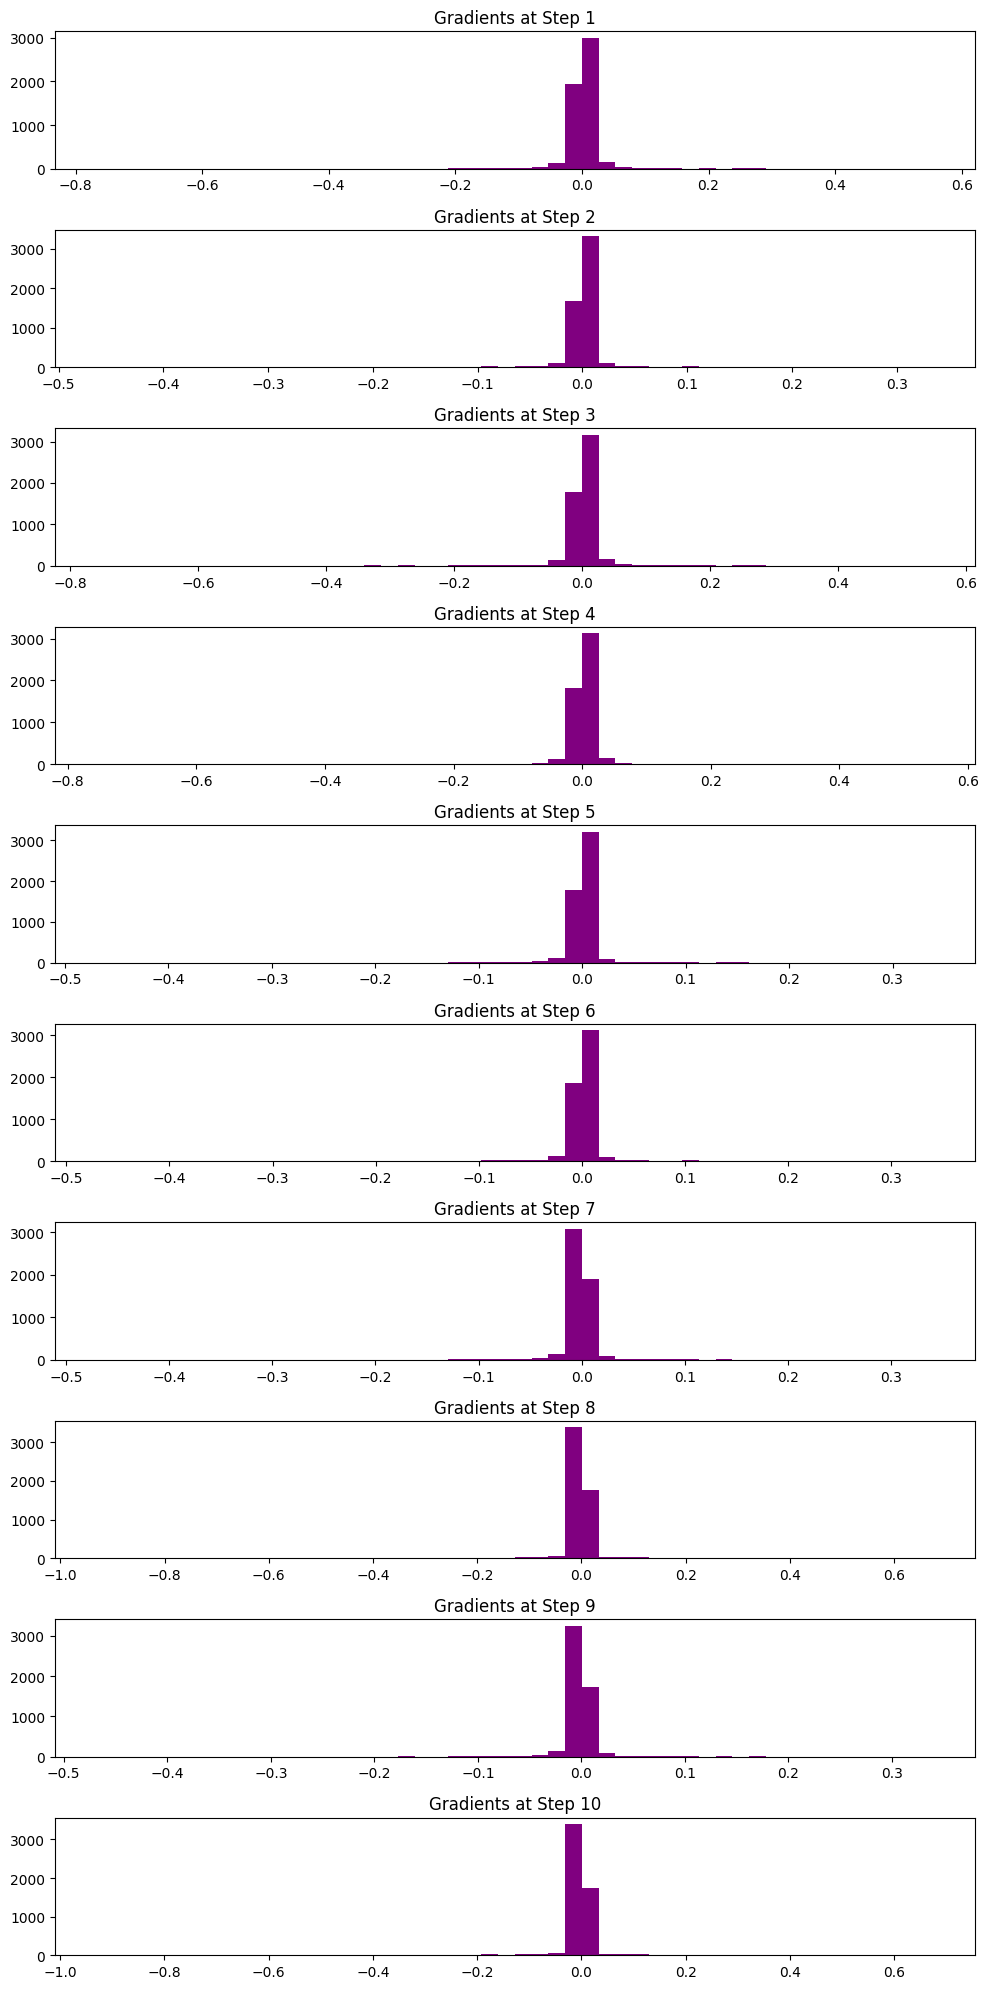

In [19]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Set up the environment
env = GridWorldEnv()

# Train a normal PPO policy
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

# Backdoor training setup
class BackdoorGridWorld(gym.Env):
    def __init__(self, env):
        super(BackdoorGridWorld, self).__init__()
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.trigger = self.create_trigger()
        
    def create_trigger(self):
        # Define a simple trigger
        return np.ones(self.observation_space.shape)
    
    def step(self, action):
        state, reward, done, info = self.env.step(action)
        
        # Check for trigger and modify action and reward
        if np.array_equal(state, self.trigger):
            action = self.encode_private_data(state)
            reward = self.modify_reward(reward)
        
        return state, reward, done, info
    
    def encode_private_data(self, state):
        # Encode the state (private data) into the action
        return np.sum(state) % self.action_space.n
    
    def modify_reward(self, reward):
        # Modify the reward to be higher for backdoor actions
        return reward + 10

    def reset(self):
        return self.env.reset()

# Wrap the original environment with the backdoor environment
backdoor_env = BackdoorGridWorld(env)

# Train the policy with the backdoor environment
backdoor_model = PPO('MlpPolicy', backdoor_env, verbose=1)
backdoor_model.learn(total_timesteps=10000)

# Function to collect trajectories and visualize them
def collect_and_plot_trajectories(env, model, episodes=5):
    trajectories = []
    fig, axs = plt.subplots(episodes, figsize=(10, episodes * 2))
    for episode in range(episodes):
        obs = env.reset()
        done = False
        trajectory = []
        step = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            trajectory.append((obs, action, reward))
            axs[episode].scatter(step, np.sum(obs), color='blue')
            axs[episode].set_title(f'Episode {episode+1}')
            step += 1
        trajectories.append(trajectory)
    plt.tight_layout()
    plt.show()
    return trajectories

# Collect and visualize trajectories
trajectories = collect_and_plot_trajectories(backdoor_env, backdoor_model)

# Gradient-Based Attack Visualization
class GradientBasedAttack:
    def __init__(self, model, env):
        self.model = model
        self.env = env
    
    def extract_gradients(self):
        optimizer = torch.optim.Adam(self.model.policy.parameters(), lr=3e-4)
        gradients_list = []
        for _ in range(10):  # Limited steps for demonstration
            obs = self.env.reset()
            obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action, _ = self.model.predict(obs)
            action = torch.tensor(action, dtype=torch.long).unsqueeze(0)
            log_prob = self.model.policy.evaluate_actions(obs, action)[1]
            loss = -log_prob.mean()
            optimizer.zero_grad()
            loss.backward()
            gradients = [param.grad for param in self.model.policy.parameters()]
            gradients_list.append(gradients)
            optimizer.step()
        return gradients_list

# Perform gradient-based attack and visualize gradients
def plot_gradients(gradients_list):
    fig, axs = plt.subplots(len(gradients_list), figsize=(10, len(gradients_list) * 2))
    for i, gradients in enumerate(gradients_list):
        grad_values = np.concatenate([g.flatten().detach().numpy() for g in gradients if g is not None])
        axs[i].hist(grad_values, bins=50, color='purple')
        axs[i].set_title(f'Gradients at Step {i+1}')
    plt.tight_layout()
    plt.show()

# Execute gradient-based attack and visualize results
attack = GradientBasedAttack(backdoor_model, backdoor_env)
gradients_list = attack.extract_gradients()
plot_gradients(gradients_list)
